In [1]:
from hossam import load_data
from pandas import DataFrame
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np

import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore, pearsonr, spearmanr

In [3]:
my_dpi = 200                                    # 이미지 선명도(100~300)
font_path = "./NotoSansKR-Regular.ttf"          # 한글을 지원하는 폰트 파일의 경로
fm.fontManager.addfont(font_path)               # 폰트의 글꼴을 시스템에 등록함
font_prop = fm.FontProperties(fname=font_path)  # 폰트의 속성을 읽어옴
font_name = font_prop.get_name()                # 읽어온 속성에서 폰트의 이름만 추출     
plt.rcParams['font.family'] = font_name         # 그래프에 한글 폰트 적용
plt.rcParams['font.size'] = 10                  # 기본 폰트크기
plt.rcParams['axes.unicode_minus'] = False      # 그래프에 마이너스 깨짐 방지(한글환경에서 필수)

baseball 데이터셋은 야구팀의 홈런수와 타율에 관한 자료이다. 홈런수와 평균타율이 상관관계
가 있는지 그 관련성을 분석하라.

In [4]:
origin = load_data('baseball')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")

print("\n===== 타입확인 =====")
print(origin.info())

origin.head()

[data] https://data.hossam.kr/data/lab11_/baseball.xlsx
[desc] 야구팀의 홈런수와 타율에 관한 자료 (출처: 방송통신대학교 통계학 개론)
[!] Cannot read metadata

===== 데이터 크기 확인 =====
데이터셋 크기: (14, 2)
열 개수: 2
행 개수: 14

===== 타입확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   홈런수     14 non-null     int64  
 1   평균타율    14 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 356.0 bytes
None


,홈런수,평균타율
0,174,0.277
1,163,0.276
2,161,0.272
3,230,0.272
4,214,0.269


선형성 가정 확인

In [5]:
xname = '홈런수'
yname = '평균타율'

x = origin[xname]
y = origin[yname]

X = sm.add_constant(x)
model = sm.OLS(y,X).fit()
reset = linear_reset(model, power=2, use_f=True)

#선형성 적합 여부(True=적합, False=부적합)
linearity_ok = reset.pvalue >0.05
print(f"Ramsey RESET Test : {'선형성 적합' if linearity_ok else '선형성 위반'} (p-value: {reset.pvalue:.4f})")

Ramsey RESET Test : 선형성 적합 (p-value: 0.0910)


In [6]:
#이상치와 왜도 검정
data = origin[[xname, yname]]
results = {}

for col in data.columns:
    temp = data[col].dropna()

    #왜도 계신
    skew_original = temp.skew()

    #Z-score 기반 이상치 탐지(|z|>3)
    z_scores = zscore(temp)
    outlier_count = int(np.sum(np.abs(z_scores)>3))

    #로그 변환 후 왜도 계산(음수 대비 +1)
    data_log = np.log1p(temp- temp.min() +1)
    skew_log = data_log.skew()

    results[col] = {
        'original_skew' :skew_original,
        'log_skew': skew_log, 
        'outliers(|z|>3)':outlier_count
    }

results_df = DataFrame(results).T
display(results_df)

#이상치 점검 결과
outlier_flag = len(results_df[results_df['outliers(|z|>3)']>0])>0
if outlier_flag:
    print("이상치가 발견되어 스피어만 상관계수 사용")
else:
    print("이상치가 발견되지 않아 피어스 상관계수 사용")

,original_skew,log_skew,outliers(|z|>3)
홈런수,0.512832,-0.974080,0.0
평균타율,0.220918,0.214929,0.0


이상치가 발견되지 않아 피어스 상관계수 사용


# 상관분석

In [11]:
report = f"본 분석에서는 {xname}과 {yname}간 상관관계를 검토하였다.\n\n"

#상관계수 선택
if linearity_ok and not outlier_flag:
    chosen = 'pearson'
    corr, pval = pearsonr(origin[xname], origin[yname])
    rationale='선형성 만족 + 왜도/이상치 영향 작음으로 판단'

    if pval>0.05:
        report += "데이터 점검 결과, 두 변수의 관계는 통계적으로 유의하지 않았다."
    else:
        report +=f"데이터 점검 결과, 두 변수의 관계는 선형적이며 이상치의 영향도 크지 않아 피어슨 상관계수를 사용하였다.\n\n분석 결과, 피어슨 상관계수는 r = {corr:0.3f}, p = {pval:0.3f}(으)로 나타나 두 변수 간 {"양의 상관" if corr > 0 else
"음의 상관"} 관계가 통계적으로 유의함을 확인하였다."
else:
    chosen = 'spearman'
    corr, pval = spearmanr(origin[xname], origin[yname])
    rationale='비선형(또는 이상치 영향)가능성 고려'

    if pval>0.05:
        report +="데이터 점검결과,  두 변수의 관계는 통계적으로 유의하지 않았다."
    else:
         report = f"데이터 점검 과정에서 비선형 관계 가능성 또는 이상치 영향이 확인되어 스피어만 상관계수를 사용하였다.\n\n분석 결과, 스피어만 상관계수는 r = {corr:0.3f}, p = {pval:0.3f}(으)로 나타나 두 변수 간 {"양의 단조" if
corr > 0 else "음의 단조"} 관계가 존재함을 확인하였다."
         
print(f"선택된 방법: {chosen}")
print(f"상관계수: {corr:.3f}")
print(f"p-value: {pval:.4f}")
print(f"선택 근거: {rationale}")
print("\n======= report =======")
print(report)

선택된 방법: pearson
상관계수: -0.075
p-value: 0.7997
선택 근거: 선형성 만족 + 왜도/이상치 영향 작음으로 판단

======= report =======
본 분석에서는 홈런수과 평균타율간 상관관계를 검토하였다.

데이터 점검 결과, 두 변수의 관계는 통계적으로 유의하지 않았다.


# 상관계수 히트맵

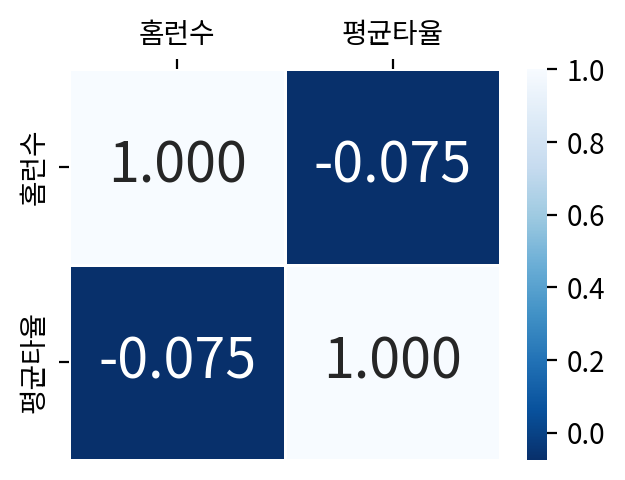

In [ ]:
corr_matrix = origin[[xname, yname]].corr(method=chosen)/

width_px = 650
height_px = 500
rows = 1
cols = 1
figsize = (width_px/ my_dpi, height_px/ my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi= my_dpi)

sb.heatmap(data=corr_matrix, annot=True, fmt="0.3f", linewidth=0.5, cmap="Blues_r", annot_kws={"size":20})


ax.set_xlabel("")
ax.set_ylabel("")
ax.xaxis.tick_top() #X축의 변수 이름을 상단으로 이동



plt.tight_layout()
plt.show()
plt.close()